# Performative Prediction: A Case Study in Strategic Classification

This notebook replicates the main experiments in [Performative Prediction](https://arxiv.org/abs/2002.06673):

- Juan C. Perdomo, Tijana Zrnic, Celestine Mendler-Dünner, Moritz Hardt. "Performative Prediction." arXiv preprint 2002.06673, 2020.

Strategic classification is a two-player game between an institution which deploys a classifier and agents who selectively adapt their features in order to improve their outcomes. This process is "performative" in the sense that the classifier deployed by the institution *causes* a change in the distribution of the target variable.

We use WhyNot to explore when repeatedly retraining the classifier on the new distributions *converges* to a stable point. For more details and theoretical calculations, see the original paper.

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

import whynot as wn
import whynot.gym as gym

import scripts.utils as utils

%matplotlib inline
import time

/Users/mehrnaz/Documents/uni/Mila/Research Readings/Performative Prediction/Whynot code/venv/lib/python3.9/site-packages/gym/envs/registration.py:415: UserWarning: WARN: The `registry.register` method is deprecated. Please use `gym.register` instead.
  logger.warn(
/Users/mehrnaz/Documents/uni/Mila/Research Readings/Performative Prediction/Whynot code/venv/lib/python3.9/site-packages/gym/envs/registration.py:415: UserWarning: WARN: The `registry.register` method is deprecated. Please use `gym.register` instead.
  logger.warn(


## Setting up the strategic classification environment

We use the [credit simulator](https://whynot.readthedocs.io/en/latest/simulators.html#credit-simulator), which is a strategic classification simulator based on the Kaggle [*Give Me Some Credit* dataset](https://www.kaggle.com/c/GiveMeSomeCredit).

In [2]:
env = gym.make('Credit-v0')
env.seed(1)

/Users/mehrnaz/Documents/uni/Mila/Research Readings/Performative Prediction/Whynot code/venv/lib/python3.9/site-packages/gym/envs/registration.py:409: UserWarning: WARN: The `registry.make` method is deprecated. Please use `gym.make` instead.
  logger.warn(
/Users/mehrnaz/Documents/uni/Mila/Research Readings/Performative Prediction/Whynot code/venv/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (18357, 11)
  logger.warn(
/Users/mehrnaz/Documents/uni/Mila/Research Readings/Performative Prediction/Whynot code/venv/lib/python3.9/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API.

[1]

## Training a baseline logistic regression classifier

The state of the environment is a dataset consisting of (1) financial features of individuals, e.g. `DebtRatio`, and (2) a binary label indicating whether an individual experienced financial distress in the subsequent two years. 

In [3]:
base_dataset = env.initial_state.values()
base_features, base_labels = base_dataset["features"], base_dataset["labels"]
num_agents, num_features = base_features.shape
print(f"The dataset has {num_agents} agents and {num_features} features.")

The dataset has 18357 agents and 11 features.


Fit a logistic regression model to the data

### Tensor RRM with Rejection Sampling

In [4]:
import scripts.utils_torch as utils_torch
import torch
import torch.optim as optim
import copy

In [5]:
def forward(features, model):
    features_t = torch.from_numpy(features)
    with torch.no_grad():
        y_hat = model(features_t)
    return y_hat.numpy()

def accuracy(preds, epsilon, labels):
    print(preds[:15])
    print((preds > (1-epsilon)/2.0)[:15])
    print(labels[:15])
    print(((preds > (1-epsilon)/2.0)*(1.0-epsilon) == labels)[:15])
    
    return ((preds > (1-epsilon)/2.0)*(1.0-epsilon) == labels).mean()

### Distribution Shift function

In [6]:
def agent_shift(features, mode, model = None, heldout_data=None):
    """Compute agent reponse to the classifier and adapt features accordingly.

    TODO: For now, the best-response model corresponds to best-response with
    linear utility and quadratic costs. We should expand this to cover a rich
    set of agent models beyond linear/quadratic, and potentially beyond
    best-response.
    """
    
    if mode == 'default':
        
        # Move everything by epsilon in the direction towards better classification
        strategic_features = np.copy(features)
        theta_strat = config.theta[config.changeable_features].flatten()
        strategic_features[:, config.changeable_features] -= config.epsilon * theta_strat
        return strategic_features
    
    elif mode == 'case1': # W1 counterexample
#         print('in agent_model and case1')
        strategic_features = np.copy(features)    
        strategic_features[:,0] = (np.tanh(config.theta[0])+2) * config.epsilon
        return strategic_features
    
    elif mode == 'RS': # Rejection Sampling case

        preds = forward(features, model)
        print(f'preds:{preds}')
        n = features.shape[0]
        r = np.random.uniform(0,1,(n,))
        resample_indices = np.random.randint(0,n,(n,))
        new_indices = np.where(r < (preds+model.epsilon), resample_indices, np.arange(n))
#         new_features = features[new_indices]
        
#         change strategic features 
        strategic_features = features[:,env.config.changeable_features]
        new_strategic_features = strategic_features[new_indices]
        new_features = np.copy(features)
        new_features[:, env.config.changeable_features] = new_strategic_features

        return new_features
        
    

In [264]:
def tensor_repeated_risk_minimization(epsilon, learning_rate, num_steps, l2_penalty, mode, layers):
    """Run repeated risk minimization for num_iters steps"""
    env.config.epsilon = epsilon
    env.config.l2_penalty = l2_penalty
    env.config.mode = mode
    print(f'strategic_features:{env.config.changeable_features}')
#     env.reset()
    
    # Track loss and accuracy before/after updating model on new distribution
    loss_start, loss_end, acc_start, acc_end, theta_gaps, f_theta_gaps = [], [], [], [], [], []
    
    if layers==1:
        model = utils_torch.onelayer_NN(epsilon, mode)
    else:
        model = utils_torch.twolayers_NN(epsilon, mode)
        
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#     optimizer = optim.Adam(model.parameters(), lr=3e-4)
#     optimizer = optim.SGD(model.parameters(), lr = 1e-3, momentum = 0.9)
    
    base_dataset = env.initial_state.values()
    base_features, base_labels = base_dataset["features"], base_dataset["labels"]
    print(f'base_labels shape:{base_labels.shape}')
    base_labels = base_labels.astype('float64')
    base_labels[base_labels==1]=1.0-epsilon

    base_features_t = torch.from_numpy(base_features)
    base_labels_t = torch.from_numpy(base_labels)


    eval_bool = False
    utils_torch.fit_logistic_regression(base_features_t, base_labels_t, l2_penalty, model, optimizer, eval_bool, mode = mode)
    
    preds = forward(base_features, model)
    base_acc = accuracy(preds, epsilon, base_labels)
    print(f'BASE ACCURACY:{base_acc}')
    
    M = 0.0
    
    labels = np.copy(base_labels)
    
    for step in range(num_steps):
        

        # Deploy classifier and observe strategic response
        ''' From the first step strategic behavior is applied so it differs for different values of epsilon '''
          
        features_strat = agent_shift(base_features, mode, model)

        # Evaluate loss and accuracy on the new distribution
        features_strat_t = torch.from_numpy(features_strat)
        labels_t = torch.from_numpy(labels)
        print(f'labels:{labels}')

        eval_bool = True
        loss_start.append(
            utils_torch.evaluate_logistic_loss(features_strat_t, labels_t, l2_penalty, model, eval_bool, mode = mode).item())
        eval_bool = False
        
        preds = forward(features_strat, model)
#         preds = forward(features_strat, model)
        theta_list = []
        with torch.no_grad():
            for weight in model.parameters():
                theta_list.append(weight.detach().clone().numpy())
                
        start_acc = accuracy(preds, epsilon, labels)
        acc_start.append(start_acc)
        print(f'start_accuracy:{start_acc}')


        M = np.maximum(M, np.max(np.abs(preds - labels)))
#         print(f'M:{M}')
        
        # Learn a new model on the induced distribution
        utils_torch.fit_logistic_regression(features_strat_t, labels_t, l2_penalty, model, optimizer, eval_bool, mode = mode)
        
        # Evaluate loss and accuracy on the strategic distribution after training
        eval_bool = True
        loss_end.append(
            utils_torch.evaluate_logistic_loss(features_strat_t, labels_t, l2_penalty, model, eval_bool, mode = mode).item()
        )
        eval_bool = False
        
        predss = forward(features_strat, model)
#         predss = forward(features_strat, model)
        end_acc = accuracy(predss, epsilon, labels)

        print()
        print(f'end_accuracy:{end_acc}')
        print()
        acc_end.append(end_acc)
        
        theta_new_list = []
        with torch.no_grad():
            for weight in model.parameters():
                theta_new_list.append(weight.detach().clone().numpy())
          
        theta_gap = 0
        for i in range(len(theta_list)):
            theta_gap += np.linalg.norm(theta_list[i]-theta_new_list[i])
            
#         print(f'theta_gap:{theta_gap}')
            
        theta_gaps.append(theta_gap)
            

        # Track distance between iterates
          
        f_theta_gap = np.sqrt(np.mean((preds - predss)**2))
        f_theta_gaps.append(f_theta_gap)
#         print(f'f_theta_gap:{f_theta_gap}')

    return loss_start, loss_end, acc_start, acc_end, theta_gaps, f_theta_gaps

## Naive Rejection Sampling

In [265]:
epsilon_list = [0.7, 0.9]
# epsilon_list = [0.9]
# epsilon_list = [0.6]
# epsilon_list = [0.7]
num_iters = 300
# mode = 'default'
mode = 'RS' # Rejection Sampling
layers = 2
l2_penalty = 1.0
learning_rates = [3e-4,3e-4,3e-4,3e-4]

loss_starts, acc_starts, loss_ends, acc_ends, theta_gaps, f_gaps = [], [], [], [], [], []
start_time = time.time()
for epsilon_idx, epsilon in enumerate(epsilon_list):
    print(f"Running retraining for epsilon {epsilon:.2f}")
    learning_rate = learning_rates[epsilon_idx]
    loss_start, loss_end, acc_start, acc_end, theta_gap, f_theta_gaps = tensor_repeated_risk_minimization(epsilon, learning_rate, num_iters, l2_penalty, mode, layers)
    loss_starts.append(loss_start)
    loss_ends.append(loss_end)
    acc_starts.append(acc_start)
    acc_ends.append(acc_end)
    theta_gaps.append(theta_gap)
    f_gaps.append(f_theta_gaps)
total_time = time.time() - start_time

Running retraining for epsilon 0.70
strategic_features:[0 5 7]
base_labels shape:(18357,)
[0.06270419 0.16602608 0.13190927 0.19320749 0.1327788  0.18526424
 0.08318073 0.29297666 0.25498469 0.28611283 0.26793707 0.17287462
 0.28870034 0.08323084 0.1048615 ]
[False  True False  True False  True False  True  True  True  True  True
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True False  True  True  True  True  True  True  True
  True  True False]
BASE ACCURACY:0.7758348313994662
preds:[0.06270419 0.16602608 0.13190927 ... 0.08176254 0.06569971 0.22102024]
labels:[0.  0.3 0.  ... 0.  0.  0.3]
[0.04508839 0.20362011 0.13190927 0.21500291 0.17575503 0.17214614
 0.08318073 0.26270943 0.21531884 0.28715775 0.27563562 0.11689014
 0.28840714 0.07890169 0.1048615 ]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  T

[0.05132486 0.2145654  0.14322731 0.15492424 0.14371475 0.20351818
 0.05374333 0.25172953 0.24453313 0.26553471 0.27730462 0.14868476
 0.27283368 0.11440254 0.08950328]
[False  True False  True False  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True False  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7563872092389824

preds:[0.0612243  0.20333596 0.14196939 ... 0.07995973 0.10505149 0.24317407]
labels:[0.  0.3 0.  ... 0.  0.  0.3]
[0.06484706 0.21313481 0.1281023  0.16126174 0.14771433 0.20567186
 0.05743198 0.23671933 0.24660235 0.26223521 0.27772028 0.15029554
 0.27701375 0.1219768  0.07594612]
[False  True False  True False  True False  True  True  True  True  True
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True False  True  True  True  True  True  True  True
  True  True False]
start_accuracy:0.

[0.08095047 0.20560311 0.11487839 0.1902631  0.16553645 0.18291913
 0.06754157 0.25453069 0.25074059 0.26359598 0.27354185 0.1410198
 0.26891153 0.1025367  0.07553181]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.755733507653756

preds:[0.05806183 0.20730231 0.13763709 ... 0.0753185  0.10414916 0.24446049]
labels:[0.  0.3 0.  ... 0.  0.  0.3]
[0.05806183 0.20894965 0.13763709 0.17323816 0.15754652 0.21495097
 0.05247434 0.25281037 0.25293988 0.26743218 0.27415406 0.13886508
 0.27143942 0.11482819 0.07595115]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.75

[0.05195396 0.21394012 0.15426526 0.17950341 0.17125479 0.21178483
 0.05081389 0.25692883 0.24311094 0.25926504 0.27265134 0.14133415
 0.27710912 0.13485655 0.05985759]
[False  True  True  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True False  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7542082039548946

preds:[0.05195396 0.20912441 0.12893958 ... 0.06953634 0.10897507 0.24261963]
labels:[0.  0.3 0.  ... 0.  0.  0.3]
[0.05550515 0.21965303 0.15426526 0.17151011 0.17100544 0.21113431
 0.06943088 0.25108915 0.24370364 0.25789792 0.26853676 0.13247769
 0.27524701 0.09970608 0.06242207]
[False  True  True  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True False  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.

[0.058685   0.20391257 0.12668418 0.14483022 0.16542842 0.21218182
 0.05268931 0.24726097 0.23037815 0.27688375 0.26717698 0.1546717
 0.27078113 0.12023266 0.0735768 ]
[False  True False False  True  True False  True  True  True  True  True
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True False  True  True  True  True  True  True  True  True
  True  True False]

end_accuracy:0.7566595848994934

preds:[0.05936654 0.20670004 0.13971408 ... 0.08225177 0.1098841  0.24063301]
labels:[0.  0.3 0.  ... 0.  0.  0.3]
[0.05936654 0.2074456  0.14437959 0.16369777 0.18075938 0.21093223
 0.07673991 0.25352925 0.23201195 0.27568324 0.26405692 0.15083113
 0.2691756  0.12038942 0.0802835 ]
[False  True False  True  True  True False  True  True  True  True  True
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True False]
start_accuracy:0.7

[0.06752803 0.20191941 0.13005771 0.15767515 0.169512   0.19238616
 0.05222386 0.25997541 0.24434168 0.26174802 0.27490287 0.13307384
 0.27297607 0.11577412 0.08083384]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7570409108242088

preds:[0.05782358 0.197653   0.13876481 ... 0.07700946 0.1073034  0.23841668]
labels:[0.  0.3 0.  ... 0.  0.  0.3]
[0.05782358 0.197653   0.1340784  0.16644893 0.14803687 0.20045826
 0.05439507 0.25676236 0.24832859 0.2573047  0.27233746 0.13204991
 0.26378536 0.11662878 0.08121369]
[False  True False  True False  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True False  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.

[0.06706262 0.20615903 0.14878577 0.19201326 0.16874911 0.20803064
 0.05478426 0.24726281 0.24137561 0.26775225 0.27179955 0.14123359
 0.27563772 0.1007281  0.07232545]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7555156071253473

preds:[0.05803277 0.20648254 0.13858225 ... 0.07933434 0.1100116  0.2315822 ]
labels:[0.  0.3 0.  ... 0.  0.  0.3]
[0.06532726 0.21005214 0.13858225 0.16529587 0.1606739  0.18385911
 0.052411   0.2570331  0.2333481  0.26649524 0.26840803 0.1304738
 0.27510602 0.09345479 0.08247271]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.7

[0.05600928 0.20729871 0.14879791 0.16902059 0.16709903 0.18337187
 0.07921137 0.25712761 0.24729869 0.26429411 0.27874764 0.13814473
 0.26857535 0.10302174 0.07632587]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7545895298796099

preds:[0.05600928 0.20683112 0.13635182 ... 0.07533587 0.10869279 0.25110541]
labels:[0.  0.3 0.  ... 0.  0.  0.3]
[0.05976137 0.215063   0.14296726 0.17489928 0.17105065 0.17984912
 0.05513853 0.25974242 0.24639456 0.26455848 0.27610158 0.14318113
 0.26819328 0.10639482 0.07685364]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.

[0.06801929 0.20267737 0.1180212  0.16744164 0.1398934  0.16996659
 0.0578389  0.25780238 0.24789525 0.25098775 0.26662358 0.12968739
 0.26743772 0.11169745 0.07224685]
[False  True False  True False  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True False  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7556245573895517

preds:[0.05950991 0.2089152  0.13462437 ... 0.08063745 0.10816788 0.24146095]
labels:[0.  0.3 0.  ... 0.  0.  0.3]
[0.07218201 0.2089152  0.13462437 0.18466516 0.16270578 0.17947888
 0.05468273 0.25139555 0.24746646 0.24322258 0.27054386 0.12968739
 0.27625081 0.07760199 0.08022788]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.

[0.06246695 0.20684423 0.14645422 0.17715524 0.14451959 0.18450494
 0.06570137 0.24812671 0.24630799 0.25360597 0.28337552 0.11565493
 0.26867807 0.10738139 0.0669181 ]
[False  True False  True False  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True False  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.755461131993245

preds:[0.05837666 0.20064392 0.13909655 ... 0.07859424 0.10720447 0.23489899]
labels:[0.  0.3 0.  ... 0.  0.  0.3]
[0.06956384 0.21011915 0.13300628 0.16709891 0.14389337 0.19079463
 0.06570137 0.25203479 0.24216859 0.25075992 0.27243734 0.15144654
 0.27186486 0.10209235 0.07912439]
[False  True False  True False  True False  True  True  True  True  True
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True False  True  True  True  True  True  True  True
  True  True False]
start_accuracy:0.7

[0.05792288 0.20387071 0.14791653 0.17757773 0.17536329 0.19556724
 0.06204049 0.25734916 0.24495517 0.27228743 0.27476551 0.13761882
 0.267395   0.09174154 0.07374367]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7559514081821649

preds:[0.0592138  0.20600682 0.1286197  ... 0.08076874 0.11201019 0.23335045]
labels:[0.  0.3 0.  ... 0.  0.  0.3]
[0.06775677 0.20443115 0.14537661 0.19697553 0.17607265 0.20274637
 0.05424756 0.25450947 0.24323264 0.26574701 0.27592835 0.14742053
 0.27270935 0.09185648 0.07307662]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.

[0.07148277 0.20589803 0.13719957 0.18236678 0.15272624 0.19101431
 0.05741675 0.26578484 0.23892451 0.27151209 0.26867532 0.14415219
 0.27228985 0.11696272 0.06450454]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.755461131993245

preds:[0.06083966 0.20589803 0.13624842 ... 0.08057644 0.11313718 0.23760807]
labels:[0.  0.3 0.  ... 0.  0.  0.3]
[0.06437505 0.19985449 0.13454169 0.16870491 0.14699561 0.19720428
 0.04861141 0.25269322 0.24470459 0.26842249 0.27345219 0.14149064
 0.26711123 0.11470272 0.06815836]
[False  True False  True False  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True False  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.7

[0.05662456 0.21154784 0.13060871 0.16462895 0.15948717 0.18933691
 0.05680437 0.2524531  0.24449835 0.24714298 0.26807618 0.12874431
 0.26253103 0.07837009 0.0753028 ]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7564961595031868

preds:[0.05662456 0.20768721 0.13356593 ... 0.07693068 0.11399281 0.23990008]
labels:[0.  0.3 0.  ... 0.  0.  0.3]
[0.06771409 0.21290603 0.14521164 0.18786643 0.17704918 0.1990536
 0.05833446 0.25858268 0.24441684 0.25118727 0.27448325 0.13762327
 0.27397777 0.0788379  0.0664178 ]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.7

[0.05725533 0.20689339 0.13276318 0.18524324 0.15885181 0.18926603
 0.04829892 0.25590063 0.22689227 0.26341302 0.27441996 0.12527576
 0.25865137 0.09144737 0.08056321]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7566051097673911

preds:[0.05889614 0.21310645 0.13187748 ... 0.08080176 0.11090705 0.23796105]
labels:[0.  0.3 0.  ... 0.  0.  0.3]
[0.05889614 0.21076216 0.13187748 0.18789248 0.16831303 0.18995744
 0.05942528 0.25284664 0.24156607 0.25643672 0.26895204 0.13622167
 0.26129227 0.10501271 0.07314816]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.

[0.06378351 0.20727663 0.13415166 0.17175312 0.16508879 0.18756792
 0.05951149 0.25124541 0.23762284 0.27455406 0.26199548 0.13444018
 0.2714246  0.09786557 0.07997666]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7549708558043253

preds:[0.05831407 0.20921648 0.13415166 ... 0.0809575  0.11505717 0.23083058]
labels:[0.  0.3 0.  ... 0.  0.  0.3]
[0.06580296 0.2159338  0.12983429 0.2120026  0.13946433 0.19338523
 0.05530644 0.24765629 0.23697293 0.27411586 0.27095969 0.13449866
 0.26939682 0.10298333 0.08463483]
[False  True False  True False  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True False  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.

[0.0616788  0.19937546 0.13472139 0.17737433 0.16889868 0.2015514
 0.0684279  0.25053992 0.23795991 0.26974835 0.26776293 0.11985583
 0.26949277 0.11051977 0.0680423 ]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7559514081821649

preds:[0.0616788  0.21312357 0.13340056 ... 0.08158223 0.11218279 0.23724391]
labels:[0.  0.3 0.  ... 0.  0.  0.3]
[0.06147668 0.21702527 0.12709517 0.2000686  0.16973306 0.19975197
 0.05916755 0.24833113 0.24957487 0.26634309 0.27124095 0.12908416
 0.26737528 0.14517205 0.06859393]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.7

[0.06046166 0.20323078 0.13134461 0.18018175 0.18136185 0.17608694
 0.05727667 0.26048971 0.24083587 0.26688053 0.27016502 0.13036526
 0.26713866 0.11197768 0.07994453]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7564961595031868

preds:[0.06046166 0.20340877 0.13134461 ... 0.08207692 0.11281769 0.23546846]
labels:[0.  0.3 0.  ... 0.  0.  0.3]
[0.05950327 0.20340877 0.14475401 0.1701579  0.16404251 0.16476622
 0.05081044 0.26006126 0.24144349 0.26284279 0.27138437 0.13799006
 0.26760636 0.11315302 0.07068423]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.

[0.07359009 0.20877205 0.12479559 0.17329747 0.15541671 0.18979679
 0.05660292 0.25414662 0.23798949 0.27139091 0.27369897 0.14253694
 0.26213192 0.11303704 0.06576496]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7549708558043253

preds:[0.05897052 0.20667176 0.13221255 ... 0.08074907 0.11529567 0.23471149]
labels:[0.  0.3 0.  ... 0.  0.  0.3]
[0.05738169 0.20848778 0.14623235 0.17572235 0.17339201 0.20230882
 0.05891839 0.24600926 0.24315283 0.27179337 0.27214384 0.14299173
 0.27168379 0.10631749 0.07948687]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.

[0.05579908 0.21302906 0.13014291 0.17701654 0.18009841 0.18444037
 0.05143517 0.25627803 0.23712141 0.2616772  0.27124321 0.14103304
 0.27556684 0.10086426 0.082408  ]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7543716293512012

preds:[0.05940043 0.20614262 0.13014291 ... 0.08209415 0.1147113  0.23371549]
labels:[0.  0.3 0.  ... 0.  0.  0.3]
[0.05940043 0.19708496 0.13139361 0.21170623 0.15082984 0.19735814
 0.06454334 0.25390449 0.23515611 0.26152515 0.26912238 0.12788961
 0.26159194 0.09797678 0.07295486]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.

[0.06429864 0.20054696 0.15974568 0.1912786  0.15614259 0.19562951
 0.05739858 0.25384534 0.24898293 0.26427744 0.27269142 0.1251517
 0.27315665 0.10415921 0.06025106]
[False  True  True  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True False  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7548074304080188

preds:[0.06002268 0.20873979 0.13044714 ... 0.08162816 0.11393268 0.23594797]
labels:[0.  0.3 0.  ... 0.  0.  0.3]
[0.0692031  0.19851069 0.145637   0.17306666 0.16722712 0.19244051
 0.05229834 0.25430382 0.24407773 0.27428865 0.27310444 0.13599203
 0.27097066 0.09609281 0.0789411 ]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.7

[0.05965605 0.21208496 0.12639217 0.18240669 0.13779355 0.19612419
 0.04585678 0.26307989 0.24405206 0.27711057 0.27449878 0.13727046
 0.28381884 0.1070101  0.06470244]
[False  True False  True False  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True False  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.756005883314267

preds:[0.05965605 0.21041367 0.13312555 ... 0.08115552 0.11171807 0.23237571]
labels:[0.  0.3 0.  ... 0.  0.  0.3]
[0.06161128 0.20384861 0.11303592 0.19569771 0.15540482 0.20354306
 0.05022256 0.25467183 0.24172289 0.26826974 0.27274443 0.13222941
 0.2756561  0.11000243 0.07776099]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.7

[0.07022188 0.19903483 0.13508196 0.18573083 0.14873287 0.19169057
 0.0631995  0.24084362 0.24778188 0.25232243 0.27281597 0.13922349
 0.27441799 0.06710315 0.07759394]
[False  True False  True False  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True False  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7551887563327341

preds:[0.05944945 0.20532148 0.13508196 ... 0.08013862 0.11438445 0.23898176]
labels:[0.  0.3 0.  ... 0.  0.  0.3]
[0.0672233  0.21717469 0.13508196 0.19115288 0.17989769 0.19080718
 0.07614553 0.24202254 0.23869718 0.25109183 0.27187666 0.14400888
 0.27022187 0.11769014 0.07822961]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.

[0.05417865 0.21043403 0.12832802 0.16834059 0.17169323 0.20307339
 0.05839618 0.25186716 0.24066935 0.25239925 0.26879479 0.13201127
 0.27089836 0.05125577 0.07753164]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7569864356921066

preds:[0.05946549 0.20801066 0.12832802 ... 0.07851168 0.11254389 0.23772737]
labels:[0.  0.3 0.  ... 0.  0.  0.3]
[0.05169964 0.20204525 0.14547272 0.20055341 0.15060177 0.17874106
 0.05083434 0.25643982 0.23936708 0.22693804 0.27147019 0.1372794
 0.27194034 0.11644181 0.07619364]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.7

[0.0558835  0.208952   0.11946583 0.19303466 0.16521701 0.19128474
 0.0645152  0.24961977 0.24481838 0.24713243 0.27684168 0.13330312
 0.26870003 0.11728786 0.07778102]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7551887563327341

preds:[0.05938285 0.20552345 0.13849389 ... 0.08101535 0.11286313 0.23648687]
labels:[0.  0.3 0.  ... 0.  0.  0.3]
[0.06823704 0.20980003 0.14508933 0.16762943 0.17293306 0.1872018
 0.0645152  0.2504145  0.2452432  0.24453803 0.27430752 0.13766772
 0.27200559 0.10824315 0.08418699]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.7

[0.05767082 0.21220774 0.13887131 0.18822061 0.16374808 0.18731975
 0.06699582 0.25379331 0.24446468 0.26914174 0.27379058 0.14403996
 0.25757455 0.11918807 0.08231195]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7549163806722231

preds:[0.05917209 0.2042546  0.13127485 ... 0.08115235 0.11420202 0.23572204]
labels:[0.  0.3 0.  ... 0.  0.  0.3]
[0.05917209 0.20181836 0.12076652 0.16545222 0.14601926 0.18596696
 0.0523786  0.25107196 0.23603078 0.27227993 0.26472535 0.14105061
 0.26297849 0.09890848 0.08456579]
[False  True False  True False  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True False  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.

[0.05796471 0.20529123 0.12806835 0.18355127 0.16582689 0.19418964
 0.05290229 0.25660173 0.24550252 0.27932801 0.2700096  0.14146528
 0.27857972 0.09698202 0.07276076]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.755733507653756

preds:[0.06013766 0.20442537 0.14081173 ... 0.07839668 0.11731767 0.23599034]
labels:[0.  0.3 0.  ... 0.  0.  0.3]
[0.0582293  0.20442537 0.12775014 0.19843546 0.14866737 0.19024191
 0.06817175 0.25525488 0.24627849 0.26670975 0.27398086 0.13117419
 0.27784358 0.11812202 0.07972631]
[False  True False  True False  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True False  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.7

[0.05934417 0.21417813 0.12825494 0.20504089 0.16698662 0.18251879
 0.05466648 0.25048901 0.23984085 0.24827029 0.27323438 0.1487635
 0.27763996 0.11695306 0.08480633]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.755733507653756

preds:[0.05673437 0.20432842 0.1349355  ... 0.07799312 0.11843264 0.23669882]
labels:[0.  0.3 0.  ... 0.  0.  0.3]
[0.06375863 0.23214521 0.14883109 0.19806851 0.15533191 0.18322088
 0.05774721 0.25300344 0.24484747 0.27287409 0.27096735 0.13078395
 0.27669361 0.11838402 0.08551567]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.75

[0.05769023 0.21054012 0.1328353  0.19866265 0.17607088 0.17918029
 0.0543908  0.25324983 0.24846074 0.28033648 0.27106252 0.14099451
 0.29162259 0.10845688 0.07614961]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7557879827858582

preds:[0.05804952 0.20311199 0.1328353  ... 0.07913918 0.11343952 0.23540406]
labels:[0.  0.3 0.  ... 0.  0.  0.3]
[0.06567452 0.20231082 0.12170605 0.18583793 0.17607088 0.17610796
 0.06198787 0.24969827 0.24698905 0.28497929 0.27545597 0.12609323
 0.25428456 0.09026598 0.0740976 ]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.

[0.06203538 0.20758441 0.13201486 0.18631944 0.18180868 0.20164957
 0.05976589 0.25031564 0.2429235  0.25467874 0.27227518 0.12599234
 0.26940605 0.11220557 0.06213016]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.756550634635289

preds:[0.06003636 0.21231947 0.13535226 ... 0.083345   0.11689439 0.23690651]
labels:[0.  0.3 0.  ... 0.  0.  0.3]
[0.06800718 0.20589104 0.14301889 0.18207748 0.16390892 0.19766007
 0.061753   0.24989193 0.24126656 0.25714316 0.27052308 0.13809151
 0.27118761 0.10572947 0.06353284]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.7

[0.05973086 0.20384812 0.13077963 0.18730714 0.14934762 0.19438879
 0.04916881 0.25401681 0.23357192 0.25518427 0.27386573 0.14395889
 0.2654842  0.09873535 0.08059883]
[False  True False  True False  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True False  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7555700822574495

preds:[0.05973086 0.20321139 0.13077963 ... 0.08080416 0.11657539 0.23435367]
labels:[0.  0.3 0.  ... 0.  0.  0.3]
[0.05973086 0.21018319 0.13602263 0.2054457  0.18303162 0.19458884
 0.05717343 0.25273951 0.23114778 0.25857682 0.27353418 0.14624818
 0.26581491 0.10443382 0.07447379]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.

[0.05751557 0.21315013 0.11741224 0.17929833 0.17175962 0.19924375
 0.05818377 0.25380297 0.24473245 0.25708387 0.27588356 0.14150333
 0.25031559 0.11142747 0.08066002]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7563872092389824

preds:[0.0584595  0.2098568  0.12944571 ... 0.07816088 0.11183726 0.24122801]
labels:[0.  0.3 0.  ... 0.  0.  0.3]
[0.05821943 0.21316989 0.11754218 0.19531157 0.14950241 0.1979177
 0.05748401 0.25008846 0.24641418 0.27632725 0.26354567 0.12703294
 0.2528004  0.1108893  0.06700872]
[False  True False  True False  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True False  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.7

[0.05605198 0.21579568 0.13342112 0.1913017  0.17697274 0.19555196
 0.05095575 0.25547875 0.24621907 0.26688941 0.26008359 0.13425709
 0.26094009 0.11090954 0.08325065]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7562237838426759

preds:[0.05863922 0.20366278 0.14235349 ... 0.08045068 0.11595379 0.24113345]
labels:[0.  0.3 0.  ... 0.  0.  0.3]
[0.06732812 0.20366278 0.1415959  0.20932047 0.18361393 0.19227804
 0.05277864 0.25716839 0.24243953 0.26930882 0.27391705 0.14595606
 0.26045905 0.11808932 0.07170117]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.

[0.05700062 0.2033797  0.14344158 0.18822675 0.14984196 0.21960427
 0.05333674 0.24907188 0.23879034 0.27788681 0.26918219 0.14781799
 0.26495954 0.08071601 0.06366372]
[False  True False  True False  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True False  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7556245573895517

preds:[0.05681751 0.20374631 0.13410855 ... 0.07975792 0.11565195 0.23285375]
labels:[0.  0.3 0.  ... 0.  0.  0.3]
[0.07140764 0.20087373 0.12304353 0.1959791  0.1574078  0.18855109
 0.05390215 0.2500074  0.24269256 0.25727838 0.27279691 0.1298966
 0.26871764 0.06826936 0.06486325]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.7

[0.0568359  0.21096995 0.14589497 0.17867773 0.14979852 0.18734332
 0.05127265 0.2537299  0.24853179 0.25175364 0.26816164 0.13017048
 0.26854873 0.11116953 0.06993301]
[False  True False  True False  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True False  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.756005883314267

preds:[0.0568359  0.21096995 0.14589497 ... 0.07816951 0.1134097  0.2369961 ]
labels:[0.  0.3 0.  ... 0.  0.  0.3]
[0.0568359  0.20924059 0.1377463  0.19804933 0.17586642 0.19620621
 0.05539039 0.25919044 0.24142172 0.25267309 0.26758369 0.12960845
 0.272805   0.05659477 0.07384169]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.3 0.  0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.7

[0.02082825 0.06995745 0.04586605 0.0571691  0.0513738  0.06654457
 0.01488525 0.0842357  0.07887976 0.08859658 0.08889261 0.04851616
 0.08928551 0.03299073 0.0257347 ]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7554066568611428

preds:[0.02068821 0.06946414 0.0460607  ... 0.02974745 0.04351289 0.07811696]
labels:[0.  0.1 0.  ... 0.  0.  0.1]
[0.02048647 0.06893649 0.04439334 0.05901288 0.0510306  0.06474279
 0.01868686 0.08473376 0.07876132 0.08895851 0.08913209 0.04638239
 0.08929762 0.0342069  0.02606212]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.

[0.01896174 0.07232927 0.04057122 0.05818038 0.05272705 0.07254407
 0.02116479 0.08157943 0.07797455 0.09018838 0.08843835 0.04757243
 0.09086682 0.03159957 0.02538798]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7545895298796099

preds:[0.01874134 0.07200096 0.04319998 ... 0.03004194 0.04091626 0.07774224]
labels:[0.  0.1 0.  ... 0.  0.  0.1]
[0.01874134 0.07056083 0.04466723 0.06019454 0.05376607 0.07242698
 0.01728118 0.08178055 0.07830083 0.08893501 0.0891981  0.04583161
 0.09218117 0.0357709  0.02498846]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.

[0.02001143 0.07309277 0.0446131  0.06290978 0.05193026 0.07532154
 0.01751765 0.0818181  0.08039007 0.08968929 0.08790685 0.04511271
 0.089503   0.03736424 0.02413839]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7543716293512012

preds:[0.02072582 0.0734243  0.04632167 ... 0.03014484 0.0427914  0.08179476]
labels:[0.  0.1 0.  ... 0.  0.  0.1]
[0.02001598 0.07381453 0.0457768  0.06307238 0.05306485 0.07496638
 0.01841871 0.08181883 0.08136083 0.08968899 0.08742825 0.04611359
 0.08948406 0.03898745 0.02427835]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.

[0.01935901 0.06963509 0.04912097 0.0646332  0.05382047 0.07135771
 0.01785497 0.08156244 0.08023209 0.08844708 0.08899284 0.04863729
 0.09282127 0.04212724 0.02469747]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7547529552759166

preds:[0.01944572 0.07120942 0.0493704  ... 0.03005131 0.04322832 0.08206157]
labels:[0.  0.1 0.  ... 0.  0.  0.1]
[0.01683717 0.06974098 0.04386966 0.06466819 0.05342795 0.07206646
 0.01824208 0.08059675 0.08183384 0.08798937 0.0902258  0.0473309
 0.09236907 0.03494091 0.02501906]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.7

[0.02064939 0.07375344 0.04193382 0.06669955 0.05484988 0.07099505
 0.01965739 0.0804463  0.08087472 0.08799962 0.08883785 0.0451083
 0.09297088 0.02968647 0.02590724]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7549163806722231

preds:[0.0191673  0.07365259 0.04515482 ... 0.0308228  0.0410637  0.07980755]
labels:[0.  0.1 0.  ... 0.  0.  0.1]
[0.01904175 0.07227859 0.04339708 0.06269066 0.05206568 0.07360298
 0.01727368 0.08214247 0.0820243  0.08806273 0.08991562 0.04703476
 0.09377749 0.03121754 0.02479032]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.7

[0.01808789 0.07143722 0.04172037 0.06824124 0.05281814 0.07310287
 0.01828148 0.08205856 0.08117627 0.08831216 0.08879917 0.04473994
 0.09421641 0.03276483 0.02538792]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7551342812006319

preds:[0.01873459 0.07088117 0.04339328 ... 0.02998863 0.04113608 0.08151544]
labels:[0.  0.1 0.  ... 0.  0.  0.1]
[0.01834059 0.07019706 0.04376701 0.06588084 0.0522672  0.07357822
 0.01939799 0.08258    0.08216598 0.08635894 0.08808056 0.04470672
 0.09398364 0.03373481 0.02614189]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.

[0.01900889 0.07431727 0.04211198 0.06516861 0.05632771 0.07105934
 0.0182093  0.08225267 0.0811633  0.093025   0.08984204 0.04713172
 0.09456203 0.03162797 0.02607432]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7550798060685298

preds:[0.01900918 0.07093322 0.0450987  ... 0.03005047 0.04238571 0.08090918]
labels:[0.  0.1 0.  ... 0.  0.  0.1]
[0.02138653 0.07433743 0.04259581 0.06496406 0.05277888 0.07066288
 0.01833826 0.08297878 0.08132535 0.09169769 0.08913404 0.04621362
 0.09451341 0.03296691 0.02292555]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.

[0.01820178 0.07360204 0.04262893 0.0634188  0.05232533 0.06660793
 0.02124157 0.08247637 0.08221099 0.09362452 0.08995255 0.04559866
 0.09338813 0.02983876 0.02684447]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7551342812006319

preds:[0.01954222 0.07009934 0.04585125 ... 0.03093241 0.04204771 0.08131994]
labels:[0.  0.1 0.  ... 0.  0.  0.1]
[0.01883025 0.07039312 0.04841453 0.06390617 0.051518   0.0694127
 0.01756974 0.08285069 0.08223882 0.08748444 0.08966244 0.04424084
 0.09480043 0.02582309 0.03136732]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.7

[0.02023779 0.07114084 0.04516853 0.06463413 0.05394511 0.06542434
 0.0188925  0.08236667 0.08068399 0.0883871  0.08996686 0.04368202
 0.0948187  0.04047684 0.0278313 ]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7552432314648363

preds:[0.01910438 0.07063635 0.04546827 ... 0.03030661 0.04189566 0.08180603]
labels:[0.  0.1 0.  ... 0.  0.  0.1]
[0.02056371 0.07113971 0.04624984 0.06381407 0.0525735  0.06525173
 0.01937693 0.08243828 0.0807875  0.09297444 0.09001375 0.04390945
 0.09505731 0.04319279 0.02709951]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.

[0.01969129 0.07074503 0.04573014 0.06635214 0.05278705 0.06394506
 0.01821542 0.08184864 0.08144039 0.09093138 0.09080027 0.04549422
 0.09468794 0.03627695 0.02695625]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7551887563327341

preds:[0.0188127  0.06985875 0.04499237 ... 0.03028314 0.0424853  0.08213845]
labels:[0.  0.1 0.  ... 0.  0.  0.1]
[0.01940612 0.07450465 0.04630725 0.0677035  0.05183296 0.06446814
 0.01743605 0.08405304 0.0824928  0.09302164 0.09058374 0.04584088
 0.09486962 0.03517786 0.02653589]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.

[0.01812905 0.07151799 0.04488084 0.06494062 0.05453745 0.06163859
 0.01779995 0.08283321 0.08075601 0.08740251 0.09014626 0.04427086
 0.09522697 0.02903105 0.02618712]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7550798060685298

preds:[0.01896335 0.07121791 0.0463873  ... 0.0306756  0.04207423 0.08128359]
labels:[0.  0.1 0.  ... 0.  0.  0.1]
[0.0191728  0.07281843 0.04458404 0.06386468 0.05480915 0.06375549
 0.01830331 0.08893956 0.08204478 0.09043977 0.08996858 0.0455247
 0.09479617 0.02834303 0.0278613 ]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.7

[0.01876288 0.07087431 0.04547058 0.06586348 0.05269082 0.06989133
 0.01824493 0.08246873 0.08103811 0.09314744 0.09033871 0.04839218
 0.09432822 0.04078257 0.02774248]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7546984801438144

preds:[0.01878156 0.07299486 0.04626129 ... 0.03084282 0.04164436 0.08207283]
labels:[0.  0.1 0.  ... 0.  0.  0.1]
[0.02015877 0.07189433 0.04616028 0.06618517 0.05334575 0.06773297
 0.01903565 0.0829496  0.08050853 0.08809617 0.09000209 0.04513065
 0.09430366 0.04049741 0.02655063]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.

[0.02078846 0.07061402 0.0459288  0.0680402  0.05225912 0.06561394
 0.01956315 0.08333152 0.08070563 0.09332092 0.09066326 0.04518276
 0.09444565 0.04088177 0.02802198]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7549708558043253

preds:[0.01963005 0.07128138 0.04452188 ... 0.02942625 0.04150443 0.08188664]
labels:[0.  0.1 0.  ... 0.  0.  0.1]
[0.02075879 0.07002877 0.04297226 0.06878847 0.05445773 0.06572911
 0.01905716 0.08300526 0.08090074 0.08659621 0.09055337 0.04391762
 0.0949871  0.04218828 0.02650479]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.

[0.02103782 0.0732881  0.04245376 0.06477571 0.05342599 0.0647063
 0.02016582 0.08320564 0.0811067  0.09432749 0.09072948 0.04539901
 0.09548528 0.04168977 0.02653874]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7548619055401209

preds:[0.01824142 0.07253078 0.04795347 ... 0.03206541 0.04257535 0.08151712]
labels:[0.  0.1 0.  ... 0.  0.  0.1]
[0.01714559 0.07083489 0.04558807 0.0651099  0.05417219 0.06529487
 0.01676302 0.08220829 0.08076359 0.09103435 0.09012684 0.04641768
 0.09448778 0.0318197  0.02747894]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.7

[0.01961623 0.07207685 0.04614954 0.06718055 0.05393904 0.06745138
 0.0191508  0.08356409 0.08305042 0.0847194  0.08748189 0.04497147
 0.0939885  0.03028239 0.0264491 ]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7545895298796099

preds:[0.01929374 0.06974891 0.04537803 ... 0.02933954 0.04158237 0.08229877]
labels:[0.  0.1 0.  ... 0.  0.  0.1]
[0.02001552 0.07245461 0.04751968 0.06615615 0.05316447 0.06827321
 0.01854394 0.08357638 0.08147711 0.08478808 0.09066234 0.04531773
 0.09436637 0.03145187 0.02596516]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.

[0.01927639 0.07053391 0.04466206 0.0631437  0.05363782 0.06594145
 0.02014901 0.08298032 0.08038138 0.08780553 0.09120336 0.04690456
 0.09346334 0.03009763 0.02679289]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7550253309364275

preds:[0.0214283  0.07117054 0.04511282 ... 0.0297412  0.04273386 0.08174281]
labels:[0.  0.1 0.  ... 0.  0.  0.1]
[0.0199093  0.07098047 0.04473931 0.06574377 0.05273687 0.06726243
 0.01731392 0.0834472  0.08210108 0.08426755 0.08784256 0.04596095
 0.0947466  0.03909574 0.02644494]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.

[0.02102767 0.07081111 0.04576631 0.06270525 0.05322262 0.06501483
 0.01849678 0.08388178 0.08149192 0.08376969 0.09051347 0.04777617
 0.09482213 0.03825445 0.02658682]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7551342812006319

preds:[0.0194996  0.07025836 0.04673804 ... 0.03057879 0.04163232 0.08162779]
labels:[0.  0.1 0.  ... 0.  0.  0.1]
[0.01893415 0.07097912 0.04358551 0.06468505 0.05239224 0.06573804
 0.01851018 0.08387585 0.08127    0.08550286 0.08975594 0.04490832
 0.09467334 0.03905776 0.02676605]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.

[0.01967604 0.0710343  0.04540271 0.06648778 0.05229148 0.06438789
 0.0183201  0.08341091 0.08330317 0.08254953 0.0893497  0.04371624
 0.09491702 0.02641249 0.02682604]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7553521817290407

preds:[0.01946097 0.07010465 0.04661409 ... 0.03079132 0.04140542 0.0819367 ]
labels:[0.  0.1 0.  ... 0.  0.  0.1]
[0.02043976 0.07137499 0.04490258 0.06561459 0.05298906 0.06419787
 0.0181395  0.08434737 0.08276717 0.08240342 0.09165718 0.04561963
 0.09407921 0.02670261 0.02733017]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.

[0.02036685 0.07065784 0.04579229 0.06662702 0.05408681 0.06803327
 0.01971716 0.08318245 0.08068478 0.08496236 0.09117057 0.04615432
 0.09170924 0.03144179 0.02706203]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7545350547475078

preds:[0.01843193 0.07057044 0.04553357 ... 0.02943042 0.04147606 0.08265065]
labels:[0.  0.1 0.  ... 0.  0.  0.1]
[0.01898258 0.07066011 0.0474709  0.06562246 0.05327157 0.06799215
 0.01803059 0.08361481 0.08147648 0.08605213 0.08907177 0.04872528
 0.09156588 0.03289346 0.02370946]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.

[0.01870652 0.06940844 0.04566459 0.06469013 0.05318121 0.06759648
 0.01738307 0.08349184 0.08329898 0.08694855 0.09006284 0.04625905
 0.0919575  0.03096866 0.02701561]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7552977065969385

preds:[0.02089417 0.06854111 0.04567918 ... 0.02925751 0.04154948 0.08151396]
labels:[0.  0.1 0.  ... 0.  0.  0.1]
[0.02102088 0.06953195 0.04616065 0.06294161 0.05420179 0.06866577
 0.01830428 0.08249118 0.08259363 0.08694781 0.08994937 0.0454376
 0.09198486 0.03130505 0.02592529]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.7

[0.02001268 0.0700712  0.05030549 0.06714991 0.05291302 0.06397258
 0.01819744 0.08330061 0.08108849 0.08338627 0.09039825 0.04562792
 0.09330995 0.02933441 0.02755581]
[False  True  True  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True False  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7561148335784714

preds:[0.01817135 0.07031601 0.0474651  ... 0.03010574 0.04138161 0.08185748]
labels:[0.  0.1 0.  ... 0.  0.  0.1]
[0.02025571 0.07006824 0.04474875 0.06707435 0.05360057 0.06565131
 0.0184072  0.0835478  0.08137539 0.08392812 0.09030453 0.04409946
 0.09288402 0.03400166 0.02765772]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.

[0.02116353 0.07066214 0.04380305 0.06610278 0.05278238 0.06918699
 0.0158699  0.08312027 0.08039974 0.09031358 0.09047112 0.04675878
 0.09030262 0.02919501 0.02715047]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7552977065969385

preds:[0.0191709  0.06780161 0.04859175 ... 0.03030101 0.04254961 0.08160862]
labels:[0.  0.1 0.  ... 0.  0.  0.1]
[0.01831391 0.06955269 0.04723618 0.06752398 0.05250667 0.06830203
 0.01922964 0.08423944 0.07884721 0.09114304 0.08935595 0.04702242
 0.0896659  0.03163876 0.02693206]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.

[0.01870154 0.07023365 0.04583514 0.06828866 0.05283421 0.06683611
 0.01861831 0.08272881 0.08076284 0.09569909 0.08877003 0.04589249
 0.09028844 0.0538557  0.0278968 ]
[False  True False  True  True  True False  True  True  True  True False
  True  True False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True False False]

end_accuracy:0.7549708558043253

preds:[0.01915115 0.07068163 0.04662525 ... 0.03001335 0.04196443 0.07988602]
labels:[0.  0.1 0.  ... 0.  0.  0.1]
[0.0194471  0.07034993 0.04931059 0.0669861  0.05381648 0.06704808
 0.01706168 0.08280438 0.08477438 0.08949281 0.08931103 0.04558063
 0.09057245 0.0450054  0.02574028]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.

[0.017015   0.07261977 0.04288125 0.06837831 0.05364085 0.06797895
 0.01637894 0.07982811 0.08042401 0.08877016 0.09162537 0.04518167
 0.0909424  0.0482633  0.02754671]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7548074304080188

preds:[0.01917886 0.07152743 0.04555684 ... 0.03068755 0.04210945 0.08110544]
labels:[0.  0.1 0.  ... 0.  0.  0.1]
[0.02018608 0.07085966 0.0473894  0.06624603 0.05359358 0.06509192
 0.02066465 0.08210898 0.08190295 0.08830586 0.09004251 0.04642301
 0.09094261 0.04826435 0.02642978]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.

[0.02095979 0.07099503 0.0460718  0.0685533  0.05264372 0.0672161
 0.01596559 0.0841708  0.08225161 0.08827762 0.0886267  0.04720584
 0.08908941 0.04899063 0.0282213 ]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7552977065969385

preds:[0.01966181 0.06943425 0.0452554  ... 0.03089865 0.04217195 0.08161323]
labels:[0.  0.1 0.  ... 0.  0.  0.1]
[0.02097987 0.07050596 0.04390522 0.06803484 0.05239646 0.06566783
 0.01686051 0.08345428 0.08076155 0.08827504 0.08863008 0.04540636
 0.08929368 0.05134358 0.0283637 ]
[False  True False  True  True  True False  True  True  True  True False
  True  True False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True False False]
start_accuracy:0.7

[0.01768112 0.07009038 0.0443365  0.07142838 0.05232999 0.06525524
 0.01598781 0.08287701 0.08187313 0.08724348 0.08855454 0.04613251
 0.08989462 0.05205258 0.02642693]
[False  True False  True  True  True False  True  True  True  True False
  True  True False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True False False]

end_accuracy:0.7551887563327341

preds:[0.01957976 0.07023511 0.04467928 ... 0.03044926 0.04214877 0.08101115]
labels:[0.  0.1 0.  ... 0.  0.  0.1]
[0.02105512 0.06980338 0.04574557 0.07135391 0.05278849 0.06561353
 0.01685202 0.08282348 0.08111472 0.08888672 0.08832292 0.04620837
 0.08980785 0.05368296 0.02619617]
[False  True False  True  True  True False  True  True  True  True False
  True  True False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True False False]
start_accuracy:0.

[0.01897492 0.06989622 0.04333309 0.06608661 0.05371601 0.06463311
 0.01583809 0.08365529 0.08109239 0.08695195 0.08881531 0.04565029
 0.08946958 0.05023108 0.02857174]
[False  True False  True  True  True False  True  True  True  True False
  True  True False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True False False]

end_accuracy:0.7552977065969385

preds:[0.01897492 0.07146989 0.04397329 ... 0.03061128 0.04275229 0.08144433]
labels:[0.  0.1 0.  ... 0.  0.  0.1]
[0.01897492 0.06967601 0.04433805 0.06985128 0.05278022 0.06402997
 0.01873992 0.08343988 0.08157804 0.08705225 0.08883454 0.046434
 0.08919852 0.04874063 0.02656754]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.75

[0.02029962 0.06951865 0.04654901 0.07146046 0.05668663 0.06489318
 0.01726119 0.08267285 0.08075449 0.08658702 0.08857236 0.04434744
 0.08805646 0.05123865 0.02926664]
[False  True False  True  True  True False  True  True  True  True False
  True  True False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True False False]

end_accuracy:0.7563872092389824

preds:[0.01900435 0.0701869  0.04664402 ... 0.0300476  0.04106119 0.0812592 ]
labels:[0.  0.1 0.  ... 0.  0.  0.1]
[0.01929692 0.06930646 0.04422042 0.06960784 0.05448649 0.06479458
 0.0175347  0.08301427 0.08077392 0.08878869 0.08934741 0.04446924
 0.09186892 0.05330332 0.02545454]
[False  True False  True  True  True False  True  True  True  True False
  True  True False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True False False]
start_accuracy:0.

[0.01898268 0.07057495 0.04426729 0.07160256 0.05482704 0.06319791
 0.01615629 0.08306763 0.08124269 0.08601061 0.09002322 0.0462617
 0.08887376 0.05223435 0.02745187]
[False  True False  True  True  True False  True  True  True  True False
  True  True False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True False False]

end_accuracy:0.7555156071253473

preds:[0.01861607 0.07010276 0.04608131 ... 0.03113223 0.04191866 0.08068114]
labels:[0.  0.1 0.  ... 0.  0.  0.1]
[0.01962467 0.06930305 0.04292966 0.0721642  0.0542038  0.06339921
 0.01728762 0.08343822 0.08251548 0.0876424  0.09017479 0.04468074
 0.0899639  0.04840021 0.0270405 ]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.7

[0.0210678  0.07091869 0.04407977 0.07100167 0.05242374 0.06610121
 0.01640537 0.08281644 0.0818029  0.08701457 0.08853663 0.04489534
 0.08783659 0.06913143 0.02729239]
[False  True False  True  True  True False  True  True  True  True False
  True  True False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True False False]

end_accuracy:0.7558424579179605

preds:[0.01837708 0.06961659 0.04490805 ... 0.03052303 0.04133898 0.08189243]
labels:[0.  0.1 0.  ... 0.  0.  0.1]
[0.01876024 0.07084812 0.04356012 0.0717539  0.05733741 0.06602651
 0.01608603 0.08220233 0.08210913 0.08758486 0.08838807 0.04679631
 0.08783392 0.05378292 0.02681525]
[False  True False  True  True  True False  True  True  True  True False
  True  True False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True False False]
start_accuracy:0.

[0.01828322 0.07034867 0.04345216 0.06999232 0.05088311 0.06778265
 0.01736408 0.08285733 0.07760831 0.08661142 0.08845282 0.04663366
 0.08773028 0.04981    0.0251409 ]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]

end_accuracy:0.7548619055401209

preds:[0.01887579 0.07091165 0.04400614 ... 0.0293851  0.04151072 0.08204955]
labels:[0.  0.1 0.  ... 0.  0.  0.1]
[0.01875373 0.06847249 0.0462544  0.06966979 0.05292589 0.06320473
 0.01576296 0.08448537 0.08052433 0.08671024 0.08921321 0.04543116
 0.08768144 0.05005    0.02643942]
[False  True False  True  True  True False  True  True  True  True False
  True  True False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True False False]
start_accuracy:0.

[0.01877801 0.07020692 0.04535733 0.073689   0.05175424 0.06911076
 0.01673199 0.08319829 0.08184732 0.08833697 0.0916275  0.04437792
 0.08619337 0.05153464 0.02762933]
[False  True False  True  True  True False  True  True  True  True False
  True  True False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True False False]

end_accuracy:0.7553521817290407

preds:[0.01817061 0.07006264 0.04454283 ... 0.03032626 0.04149607 0.08178459]
labels:[0.  0.1 0.  ... 0.  0.  0.1]
[0.01859265 0.06931558 0.04453158 0.07015485 0.05254008 0.06573034
 0.0180253  0.08363062 0.08178261 0.08724904 0.08861982 0.04749979
 0.08664039 0.04952458 0.02677545]
[False  True False  True  True  True False  True  True  True  True False
  True False False]
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False]
start_accuracy:0.

In [68]:
print(f"total time:{total_time}")

total time:342.94967889785767


### Visualizing the loss

#### Loading from previous runs

In [267]:
import pickle
f_gaps_c = []
theta_gaps_c = []
loss_starts_c = []
loss_ends_c = []
acc_starts_c = []
acc_ends_c = []

dir_name = 'HiddenLayers/h8-300'#d=8

file_name = "./Results/"+dir_name+"/f_gaps.pkl"
with open("./Results/"+dir_name+"/f_gaps.pkl", 'rb') as f:
    f_gaps = pickle.load(f)
    f_gaps_c.append(f_gaps)
    
with open("./Results/"+dir_name+"/theta_gaps.pkl", 'rb') as f:
    theta_gaps = pickle.load(f)
    theta_gaps_c.append(theta_gaps)
    
with open("./Results/"+dir_name+"/loss_starts.pkl", 'rb') as f:
    loss_starts = pickle.load(f)
    loss_starts_c.append(loss_starts)
    
with open("./Results/"+dir_name+"/loss_ends.pkl", 'rb') as f:
    loss_ends = pickle.load(f)
    loss_ends_c.append(loss_ends)
    
with open("./Results/"+dir_name+"/acc_starts.pkl", 'rb') as f:
    acc_starts = pickle.load(f)
    acc_starts_c.append(acc_starts)
    
with open("./Results/"+dir_name+"/acc_ends.pkl", 'rb') as f:
    acc_ends = pickle.load(f)
    acc_ends_c.append(acc_ends)

In [268]:
dir_name = 'HiddenLayers/h16-300'#d=16

file_name = "./Results/"+dir_name+"/f_gaps.pkl"
with open("./Results/"+dir_name+"/f_gaps.pkl", 'rb') as f:
    f_gaps = pickle.load(f)
    f_gaps_c.append(f_gaps)
    
with open("./Results/"+dir_name+"/theta_gaps.pkl", 'rb') as f:
    theta_gaps = pickle.load(f)
    theta_gaps_c.append(theta_gaps)
    
with open("./Results/"+dir_name+"/loss_starts.pkl", 'rb') as f:
    loss_starts = pickle.load(f)
    loss_starts_c.append(loss_starts)
    
with open("./Results/"+dir_name+"/loss_ends.pkl", 'rb') as f:
    loss_ends = pickle.load(f)
    loss_ends_c.append(loss_ends)
    
with open("./Results/"+dir_name+"/acc_starts.pkl", 'rb') as f:
    acc_starts = pickle.load(f)
    acc_starts_c.append(acc_starts)
    
with open("./Results/"+dir_name+"/acc_ends.pkl", 'rb') as f:
    acc_ends = pickle.load(f)
    acc_ends_c.append(acc_ends)

In [269]:
dir_name = 'HiddenLayers/h32-300'#d=32

file_name = "./Results/"+dir_name+"/f_gaps.pkl"
with open("./Results/"+dir_name+"/f_gaps.pkl", 'rb') as f:
    f_gaps = pickle.load(f)
    f_gaps_c.append(f_gaps)
    
with open("./Results/"+dir_name+"/theta_gaps.pkl", 'rb') as f:
    theta_gaps = pickle.load(f)
    theta_gaps_c.append(theta_gaps)
    
with open("./Results/"+dir_name+"/loss_starts.pkl", 'rb') as f:
    loss_starts = pickle.load(f)
    loss_starts_c.append(loss_starts)
    
with open("./Results/"+dir_name+"/loss_ends.pkl", 'rb') as f:
    loss_ends = pickle.load(f)
    loss_ends_c.append(loss_ends)
    
with open("./Results/"+dir_name+"/acc_starts.pkl", 'rb') as f:
    acc_starts = pickle.load(f)
    acc_starts_c.append(acc_starts)
    
with open("./Results/"+dir_name+"/acc_ends.pkl", 'rb') as f:
    acc_ends = pickle.load(f)
    acc_ends_c.append(acc_ends)

In [172]:
dir_name = 'HiddenLayers/h64'#d=64

file_name = "./Results/"+dir_name+"/f_gaps.pkl"
with open("./Results/"+dir_name+"/f_gaps.pkl", 'rb') as f:
    f_gaps = pickle.load(f)
    f_gaps_c.append(f_gaps)
    
with open("./Results/"+dir_name+"/theta_gaps.pkl", 'rb') as f:
    theta_gaps = pickle.load(f)
    theta_gaps_c.append(theta_gaps)
    
with open("./Results/"+dir_name+"/loss_starts.pkl", 'rb') as f:
    loss_starts = pickle.load(f)
    loss_starts_c.append(loss_starts)
    
with open("./Results/"+dir_name+"/loss_ends.pkl", 'rb') as f:
    loss_ends = pickle.load(f)
    loss_ends_c.append(loss_ends)
    
with open("./Results/"+dir_name+"/acc_starts.pkl", 'rb') as f:
    acc_starts = pickle.load(f)
    acc_starts_c.append(acc_starts)
    
with open("./Results/"+dir_name+"/acc_ends.pkl", 'rb') as f:
    acc_ends = pickle.load(f)
    acc_ends_c.append(acc_ends)

In [226]:
dir_name = 'HiddenLayers/h32-2'#d=60

file_name = "./Results/"+dir_name+"/f_gaps.pkl"
with open("./Results/"+dir_name+"/f_gaps.pkl", 'rb') as f:
    f_gaps = pickle.load(f)
    f_gaps_c.append(f_gaps)
    
with open("./Results/"+dir_name+"/theta_gaps.pkl", 'rb') as f:
    theta_gaps = pickle.load(f)
    theta_gaps_c.append(theta_gaps)
    
with open("./Results/"+dir_name+"/loss_starts.pkl", 'rb') as f:
    loss_starts = pickle.load(f)
    loss_starts_c.append(loss_starts)
    
with open("./Results/"+dir_name+"/loss_ends.pkl", 'rb') as f:
    loss_ends = pickle.load(f)
    loss_ends_c.append(loss_ends)
    
with open("./Results/"+dir_name+"/acc_starts.pkl", 'rb') as f:
    acc_starts = pickle.load(f)
    acc_starts_c.append(acc_starts)
    
with open("./Results/"+dir_name+"/acc_ends.pkl", 'rb') as f:
    acc_ends = pickle.load(f)
    acc_ends_c.append(acc_ends)

$\epsilon$=:0.1


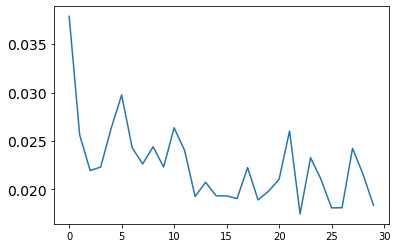

$\epsilon$=:0.4


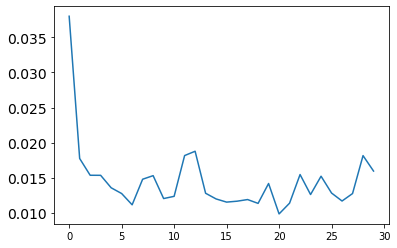

$\epsilon$=:0.7


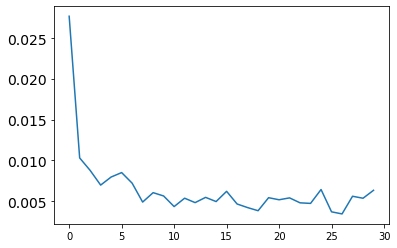

$\epsilon$=:0.9


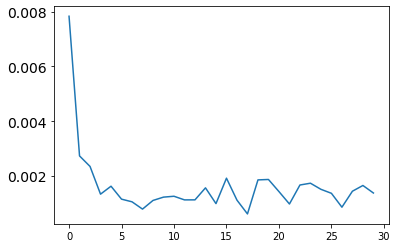

In [70]:
for i, eps in enumerate(epsilon_list):
    print(f'$\epsilon$=:{eps}')
    plt.plot(np.arange(num_iters), f_gaps[i])
    plt.show()

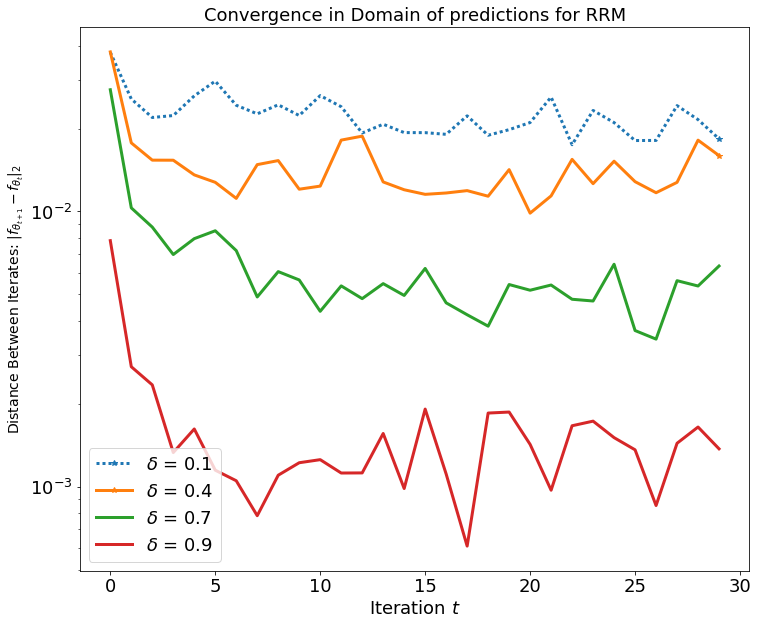

In [71]:
# for i in range(4):
#     print(len(theta_gaps[i]))
epsilon_list = [0.1 , 0.4, 0.7, 0.9]

''' WHY X!= 0.0 ?? '''
# print(theta_gaps[2])
# processed_theta_gaps = [[x for x in tg if x != 0.0] for tg in theta_gaps]

# for i in range(4):
#     print(len(processed_theta_gaps[i]))
    
_, ax = plt.subplots(figsize=(12, 10))

for idx, (gaps, eps) in enumerate(zip(f_gaps, epsilon_list)):
    label = '$\delta$ = {}'.format(eps)
    if idx == 0:
        ax.semilogy(gaps, label=label, linewidth=3,  alpha=1,
                 markevery=[-1], marker='*', linestyle=(0, (1, 1)))
    elif idx == 1:
        ax.semilogy(gaps, label=label, linewidth=3,  alpha=1,
                 markevery=[-1], marker='*', linestyle='solid')
    else:
        ax.semilogy(gaps, label=label, linewidth=3)


ax.set_title("Convergence in Domain of predictions for RRM", fontsize=18)
ax.set_xlabel('Iteration $t$',fontsize=18)
ax.set_ylabel(r'Distance Between Iterates: $\|f_{\theta_{t+1}} - f_{\theta_{t}}\|_2 $', fontsize=14)
ax.tick_params(labelsize=18)
plt.legend(fontsize=18)

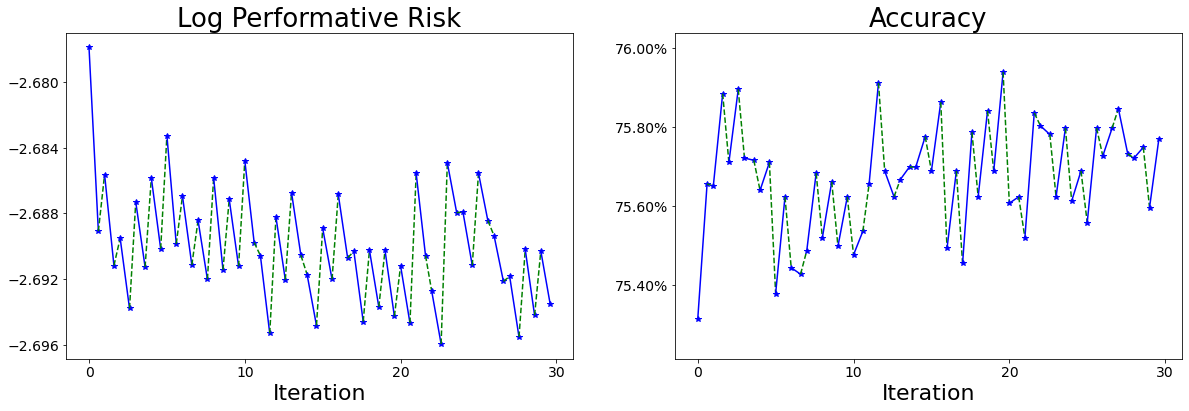

In [72]:
import matplotlib.ticker as mtick

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
# for idx, epsilon in enumerate(epsilon_list):
idx = 0
ax = axes[0]
offset = 0.6
loss_starts_log = np.log(np.array(loss_starts))
loss_ends_log = np.log(np.array(loss_ends))

ax.set_title("Log Performative Risk", fontsize=26)
#     print(len(loss_starts[idx]))
#     print(num_iters)

for i in range( 0, num_iters):
    ax.plot([i,i + offset],[loss_starts_log[idx][i], loss_ends_log[idx][i]],'b*-')
    if i < num_iters - 1:
        ax.plot([i + offset, i + 1],[loss_ends_log[idx][i], loss_starts_log[idx][i + 1]],'g--')

ax.set_xlabel("Iteration", fontsize=22)
# if idx%2 == 0:
#     ax.set_ylabel("Performative Risk", fontsize=16)
# ax.set_yscale('log')
# ax.yaxis.set_major_locator(plt.MaxNLocator(5))
# ax.yaxis.set_major_locator(mtick.LogLocator(numticks=4))
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_major_locator(plt.MaxNLocator(5))
ax.tick_params(axis='both', labelsize=14)
plt.rcParams['ytick.labelsize']=14

acc_starts_np = np.array(acc_starts) * 100
acc_ends_np = np.array(acc_ends) * 100

minimum = 100
maximum = 0
ax = axes[1]
offset = 0.6
ax.set_title("Accuracy", fontsize=26)
for i in range(0, num_iters):
    ax.plot([i,i + offset],[acc_starts_np[idx][i], acc_ends_np[idx][i]],'b*-')
    if i < num_iters - 1:
        ax.plot([i+offset, i + 1],[acc_ends_np[idx][i], acc_starts_np[idx][i + 1]],'g--')

    minimum = min(minimum, acc_starts_np[idx][i])
    minimum = min(minimum, acc_ends_np[idx][i])
    maximum = max(maximum, acc_starts_np[idx][i])
    maximum = max(maximum, acc_ends_np[idx][i])

ax.set_xlabel("Iteration", fontsize=22)
ax.yaxis.set_major_locator(plt.MaxNLocator(5))
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.tick_params(axis='both', labelsize=14)

# ax.locator_params(axis='y', nbins=5)

# if idx%2 == 0 :
#     ax.set_ylabel("Accuracy", fontsize=16)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylim([minimum-0.1, maximum+0.1])
plt.subplots_adjust(hspace=0.25)

# fig.savefig('./Results/Run13/result.png', dpi=300)

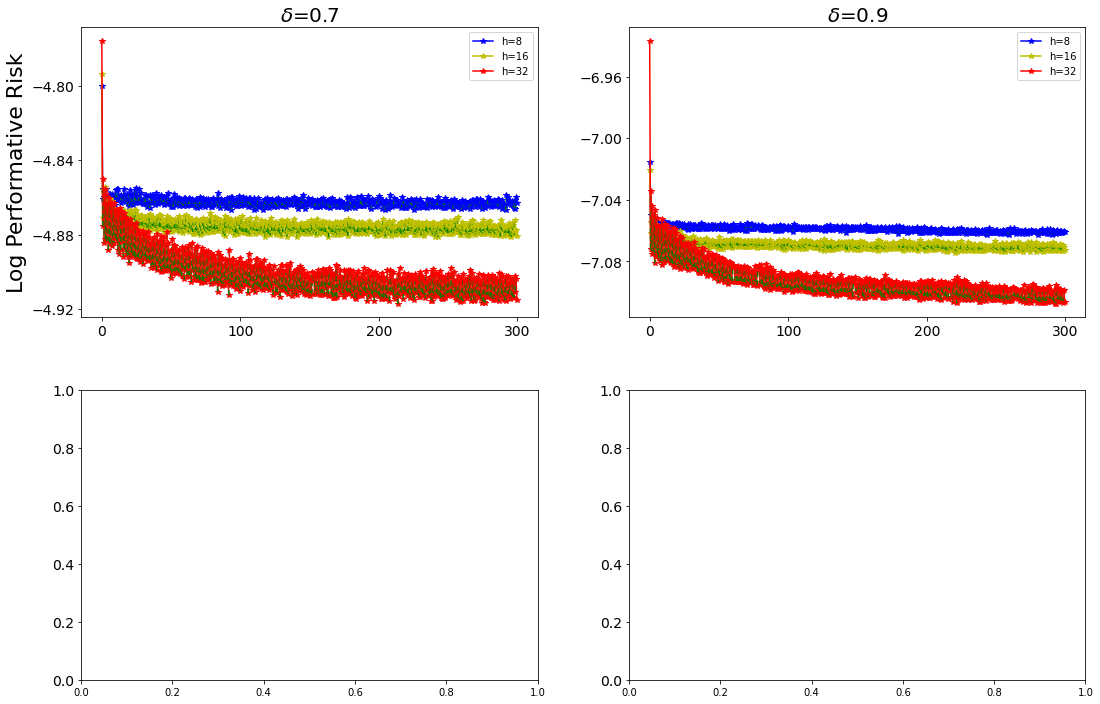

In [280]:
epsilon_list = [0.7, 0.9]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
loss_starts_log = np.log(np.array(loss_starts))
loss_ends_log = np.log(np.array(loss_ends))

for idx, epsilon in enumerate(epsilon_list):
    ax = axes[idx // 2][idx % 2]
    offset = 0.6
    ax.set_title(f"$\delta$={epsilon}", fontsize=20)
#     print(len(loss_starts[idx]))
#     print(num_iters)
    num_iters=300
    for k in range(3):
        loss_starts=loss_starts_c[k]
        loss_ends=loss_ends_c[k]
        loss_starts_log = np.log(np.array(loss_starts))
        loss_ends_log = np.log(np.array(loss_ends))
        if k==0:
            for i in range( 0, num_iters):
                if i==0:
                    ax.plot([i,i + offset],[loss_starts_log[idx][i], loss_ends_log[idx][i]],'b*-', label='h=8')
                else: 
                    ax.plot([i,i + offset],[loss_starts_log[idx][i], loss_ends_log[idx][i]],'b*-')
                    
                if i < num_iters - 1:
                    ax.plot([i + offset, i + 1],[loss_ends_log[idx][i], loss_starts_log[idx][i + 1]],'g--')
                
        elif k==1:
            for i in range( 0, num_iters):
                if i==0:
                    ax.plot([i,i + offset],[loss_starts_log[idx][i], loss_ends_log[idx][i]],'y*-', label='h=16')
                else:
                    ax.plot([i,i + offset],[loss_starts_log[idx][i], loss_ends_log[idx][i]],'y*-')

                if i < num_iters - 1:
                    ax.plot([i + offset, i + 1],[loss_ends_log[idx][i], loss_starts_log[idx][i + 1]],'g--')
                    
        elif k==2:
            for i in range( 0, num_iters):
                if i==0:
                    ax.plot([i,i + offset],[loss_starts_log[idx][i], loss_ends_log[idx][i]],'r*-', label='h=32')
                else:
                    ax.plot([i,i + offset],[loss_starts_log[idx][i], loss_ends_log[idx][i]],'r*-')

                if i < num_iters - 1:

                    ax.plot([i + offset, i + 1],[loss_ends_log[idx][i], loss_starts_log[idx][i + 1]],'g--')
                    
        elif k==3:
            for i in range( 0, num_iters):
                if i==0:
                    ax.plot([i,i + offset],[loss_starts_log[idx][i], loss_ends_log[idx][i]],'c*-', label='h=64')
                else:
                    ax.plot([i,i + offset],[loss_starts_log[idx][i], loss_ends_log[idx][i]],'c*-')

                if i < num_iters - 1:

                    ax.plot([i + offset, i + 1],[loss_ends_log[idx][i], loss_starts_log[idx][i + 1]],'g--')
                
        ax.xaxis.set_major_locator(plt.MaxNLocator(4))
        ax.tick_params(axis='both', labelsize=14)
        plt.rcParams['ytick.labelsize']=14
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))
        ax.legend()

    if idx%2 == 0 :
        ax.set_ylabel("Log Performative Risk", fontsize=22)
    if idx>1:
        ax.set_xlabel("Iteration", fontsize=22)
        
plt.subplots_adjust(hspace=0.25)
fig.savefig('./Results/HiddenLayers/different_hiddens.png', dpi=600)

IndexError: index 2 is out of bounds for axis 0 with size 2

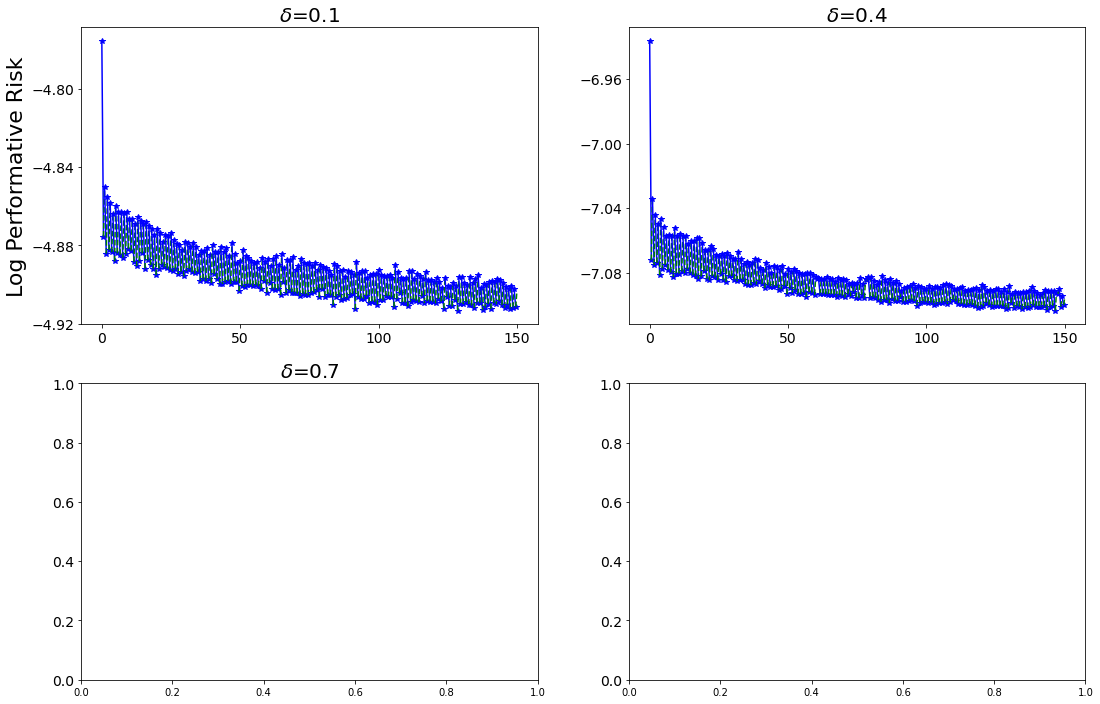

In [247]:
epsilon_list = [0.1 , 0.4, 0.7, 0.9]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
loss_starts_log = np.log(np.array(loss_starts))
loss_ends_log = np.log(np.array(loss_ends))

for idx, epsilon in enumerate(epsilon_list):
    ax = axes[idx // 2][idx % 2]
    offset = 0.6
    ax.set_title(f"$\delta$={epsilon}", fontsize=20)
#     print(len(loss_starts[idx]))
#     print(num_iters)
    for i in range( 0, 150):
        if i==0:
            ax.plot([i,i + offset],[loss_starts_log[idx][i], loss_ends_log[idx][i]],'b*-')
        else: 
            ax.plot([i,i + offset],[loss_starts_log[idx][i], loss_ends_log[idx][i]],'b*-')

        if i < num_iters - 1:
            ax.plot([i + offset, i + 1],[loss_ends_log[idx][i], loss_starts_log[idx][i + 1]],'g--')
                
        ax.xaxis.set_major_locator(plt.MaxNLocator(4))
        ax.tick_params(axis='both', labelsize=14)
        plt.rcParams['ytick.labelsize']=14
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))

    if idx%2 == 0 :
        ax.set_ylabel("Log Performative Risk", fontsize=22)
    if idx>1:
        ax.set_xlabel("Iteration", fontsize=22)
        
plt.subplots_adjust(hspace=0.25)
# fig.savefig('./Results/Run14/loss_different_delta.png', dpi=300)

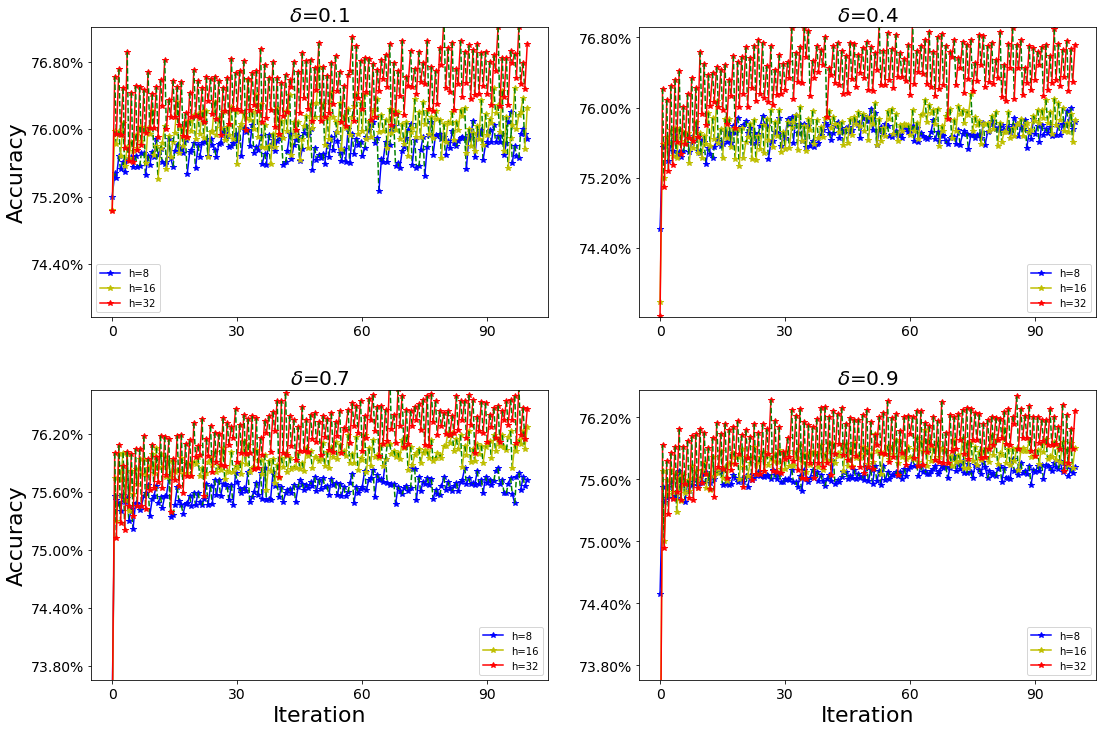

In [195]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))


for idx, epsilon in enumerate(epsilon_list):
#     acc_starts_np = np.array(acc_starts) * 100
#     acc_ends_np = np.array(acc_ends) * 100

    minimum = 100
    maximum = 0
    ax = axes[idx // 2][idx % 2]
    offset = 0.6
    ax.set_title(f"$\delta$={epsilon}", fontsize=20)
    for k in range(3):
        acc_starts = acc_starts_c[k]
        acc_ends = acc_ends_c[k]
        acc_starts_np = np.array(acc_starts) * 100
        acc_ends_np = np.array(acc_ends) * 100

        if k==0:
            for i in range(0, num_iters):
                if i==0:
                    ax.plot([i,i + offset],[acc_starts_np[idx][i], acc_ends_np[idx][i]],'b*-', label='h=8')
                else:
                    ax.plot([i,i + offset],[acc_starts_np[idx][i], acc_ends_np[idx][i]],'b*-')

                if i < num_iters - 1:
                    ax.plot([i+offset, i + 1],[acc_ends_np[idx][i], acc_starts_np[idx][i + 1]],'g--')
                    
        elif k==1:
            for i in range(0, num_iters):
                if i==0:
                    ax.plot([i,i + offset],[acc_starts_np[idx][i], acc_ends_np[idx][i]],'y*-', label='h=16')
                else:
                    ax.plot([i,i + offset],[acc_starts_np[idx][i], acc_ends_np[idx][i]],'y*-')

                if i < num_iters - 1:
                    ax.plot([i+offset, i + 1],[acc_ends_np[idx][i], acc_starts_np[idx][i + 1]],'g--')
        elif k==2:
            
            for i in range(0, num_iters):
                if i==0:
                    ax.plot([i,i + offset],[acc_starts_np[idx][i], acc_ends_np[idx][i]],'r*-', label='h=32')
                else:
                    ax.plot([i,i + offset],[acc_starts_np[idx][i], acc_ends_np[idx][i]],'r*-')

                if i < num_iters - 1:
                    ax.plot([i+offset, i + 1],[acc_ends_np[idx][i], acc_starts_np[idx][i + 1]],'g--')
        else:
            
            for i in range(0, num_iters):
                if i==0:
                    ax.plot([i,i + offset],[acc_starts_np[idx][i], acc_ends_np[idx][i]],'c*-', label='h=64')
                else:
                    ax.plot([i,i + offset],[acc_starts_np[idx][i], acc_ends_np[idx][i]],'c*-')

                if i < num_iters - 1:
                    ax.plot([i+offset, i + 1],[acc_ends_np[idx][i], acc_starts_np[idx][i + 1]],'g--')
            
        ax.legend()
        minimum = min(minimum, acc_starts_np[idx][i])
        minimum = min(minimum, acc_ends_np[idx][i])
        maximum = max(maximum, acc_starts_np[idx][i])
        maximum = max(maximum, acc_ends_np[idx][i])

        ax.xaxis.set_major_locator(plt.MaxNLocator(4))
        ax.tick_params(axis='both', labelsize=14)
        plt.rcParams['ytick.labelsize']=14
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))
        if idx%2 == 0 :
            ax.set_ylabel("Accuracy", fontsize=22)
        if idx>1:
            ax.set_xlabel("Iteration", fontsize=22)

        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        ax.set_ylim([minimum-2, maximum+0.2])
        plt.subplots_adjust(hspace=0.25)

[2.125692163390765, 1.4908810029708675, 0.44640388200024683, 1.979137759175216, 1.1523877346616307, 1.2450400822121048, 1.3882156644118282, 0.5021358815400228, 0.23153974136439337, 0.3408914427664492, 0.6592829205648013, 0.44890461993485126, 0.35480964329069364, 0.3524904730647268, 0.5412156407229263, 0.39942841163756326, 0.3639458631231947, 0.03759688177977612, 0.3990636250160708, 0.3512729516457045, 0.3098898303664165, 0.36140960910977005, 0.5087812733183279, 0.04240655551393738, 0.04417748297611328, 0.2988453816312263, 0.20921551058050813, 0.14973468565427497, 0.2540291853165447, 0.3646814230793913]


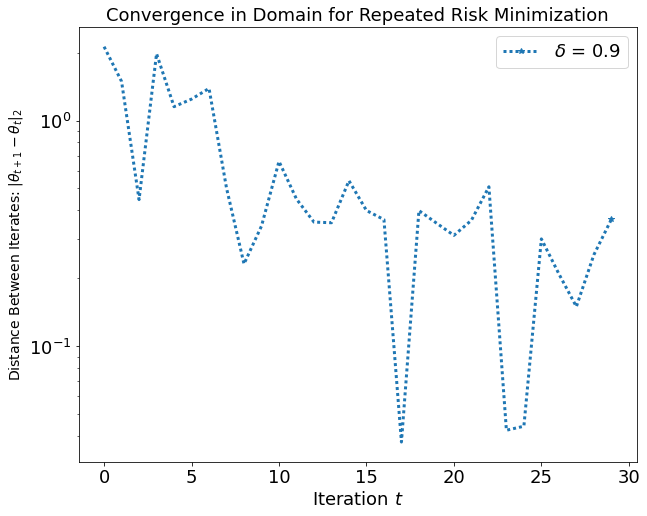

In [135]:
# for i in range(4):
#     print(len(theta_gaps[i]))

''' WHY X!= 0.0 ?? '''
# print(theta_gaps[2])
processed_theta_gaps = [[x for x in tg if x != 0.0] for tg in theta_gaps]
print(theta_gaps[0])

# for i in range(4):
#     print(len(processed_theta_gaps[i]))
    
_, ax = plt.subplots(figsize=(10, 8))

for idx, (gaps, eps) in enumerate(zip(processed_theta_gaps, epsilon_list)):
    label = '$\delta$ = {}'.format(eps)
    if idx == 0:
        ax.semilogy(gaps, label=label, linewidth=3,  alpha=1,
                 markevery=[-1], marker='*', linestyle=(0, (1, 1)))
    elif idx == 1:
        ax.semilogy(gaps, label=label, linewidth=3,  alpha=1,
                 markevery=[-1], marker='*', linestyle='solid')
    else:
        ax.semilogy(gaps, label=label, linewidth=3)


ax.set_title("Convergence in Domain for Repeated Risk Minimization", fontsize=18)
ax.set_xlabel('Iteration $t$',fontsize=18)
ax.set_ylabel(r'Distance Between Iterates: $\|\theta_{t+1} - \theta_{t}\|_2 $', fontsize=14)
ax.tick_params(labelsize=18)
plt.legend(fontsize=18)

### Save the results

In [266]:
import pickle

dir_name = 'HiddenLayers/h8-300'

file_name = "./Results/"+dir_name+"/f_gaps.pkl"
with open("./Results/"+dir_name+"/f_gaps.pkl", 'wb') as f:
    pickle.dump(f_gaps, f)
    
with open("./Results/"+dir_name+"/theta_gaps.pkl", 'wb') as f:
    pickle.dump(theta_gaps, f)
    
with open("./Results/"+dir_name+"/loss_starts.pkl", 'wb') as f:
    pickle.dump(loss_starts, f)
    
with open("./Results/"+dir_name+"/loss_ends.pkl", 'wb') as f:
    pickle.dump(loss_ends, f)
    
with open("./Results/"+dir_name+"/acc_starts.pkl", 'wb') as f:
    pickle.dump(acc_starts, f)
    
with open("./Results/"+dir_name+"/acc_ends.pkl", 'wb') as f:
    pickle.dump(acc_ends, f)